In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy
from scipy.integrate import quad as integrate
from functools import cmp_to_key
import pyscf

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [175]:
def NC(l):
    if l < 0:
        return 0
    return (l+1)*(l+2)//2

def Boys(T, m):
    def boys_int_func( t, T, m ):
        return t**(2*m) * np.exp(-T*t**2)
    ret, _ = integrate( boys_int_func, 0, 1, args=(T,m) )
    return ret

class Shell:
    def __init__(self, i_, l_, np_, nc_ ):
        self.L = l_
        self.np = np_
        self.nc = nc_
        self.i = i_
        self.R = np.zeros(shape = 3)
        self.z = np.zeros(shape = np_)
        self.k = np.zeros(shape = (np_,nc_))
        
    def __repr__(self):
        ret =  " shell " + str(self.i) + " at " + str(self.R)  + "\n"
        ret += "      L: " + str(self.L) + "\n"
        ret += "      np: " + str(self.np) + "\n"
        ret += "      nc: " + str(self.nc) + "\n"
        ret += "      z: " + str(self.z) + "\n"
        ret += "      K: " + str(self.k) + "\n"
        return ret

def Knorm( z1,z2,R1,R2 ):
    return np.sqrt(2.) * (np.pi)**(5/4) / (z1+z2) * np.exp( - z1*z2/(z1+z2)*np.sum((R1-R2)**2) )

def lx( i, L ):
    for l in range(100):
        if ( i < NC(l) ): return L-l;
    assert(False)

def lz( i, L, lx_=None ):
    if lx_ == None:
        lx_ = lx(i,L)
    i0 = NC(L-lx_-1)
    lz_ = i - i0
    return lz_

def ly(i,L,lx_=None):
    if lx_ == None:
        lx_ = lx(i,L)
    lz_ = lz(i,L,lx_)
    return L-lx_-lz_  


class OSvectors:
    pass

def compute_V( a,b,c,d, ipa,ipb,ipc,ipd):
    A = a.R
    B = b.R #+ G
    C = c.R #+ H
    D = d.R #+ N + H

    za = a.z[ipa]
    zb = b.z[ipb]
    zc = c.z[ipc]
    zd = d.z[ipd]
    
    ka = a.k[ipa]
    kb = b.k[ipb]
    kc = c.k[ipc]
    kd = d.k[ipd]

    zp  = za+zb
    zq  = zc+zd
    z   = zp+zq
    rho = zp*zq/z

    aux = OSvectors()
    
    aux.zp1 = 1./(2.*zp)
    aux.zp2 = - rho/(2.*zp**2)
    aux.zq1 = 1./(2.*zq)
    aux.zq2 = - rho/(2.*zq**2)
    aux.i2z = 1. / 2. / z

    P = ( za*A + zb*B ) / zp
    Q = ( zc*C + zd*D ) / zq
    W = ( zp*P + zq*Q ) / z
    
    aux.PA = P - A
    aux.PB = P - B
    aux.QC = Q - C
    aux.QD = Q - D
    aux.WQ = W - Q
    aux.WP = W - P
    aux.PQ = P - Q
    rpq2 = np.sum(aux.PQ**2)
    aux.T  = rho * rpq2
    
    K  = ka*kb*kc*kd
    K1 = Knorm( za,zb,A,B )
    K2 = Knorm( zc,zd,C,D )
    aux.Kfac = K * K1 * K2 / np.sqrt(z) / 16./np.pi**2
    
    aux.gap = 2.*za
    aux.gbp = 2.*zb
    aux.gcp = 2.*zc
    aux.gdp = 2.*zd

    return aux

def compute_cost( la,lb,lc,ld, d):
    na,nb,nc,nd = NC(la-0),NC(lb-0),NC(lc-0),NC(ld-0)
    ma,mb,mc,md = NC(la-1),NC(lb-1),NC(lc-1),NC(ld-1)
    wa,wb,wc,wd = NC(la-2),NC(lb-2),NC(lc-2),NC(ld-2)
    
    cost = 0
    if d == 'A':
        ne,me,we = na,ma,wa
        nu,mu = nb,mb
        no,mo = nc,mc
        ny,my = nd,md
        
    if d == 'B':
        ne,me,we = nb,mb,wb
        nu,mu = na,ma
        no,mo = nc,mc
        ny,my = nd,md
        
    if d == 'C':
        ne,me,we = nc,mc,wc
        nu,mu = nd,md
        no,mo = na,ma
        ny,my = nb,mb
        
    if d == 'D':
        ne,me,we = nd,md,wd
        nu,mu = nc,mc
        no,mo = na,ma
        ny,my = nb,mb
        
    cost += 1.  * 2 * 3 * me*nu*no*ny
    cost += 1.  * 2 * 3 * we*nu*no*ny
    cost += 1.  * 2 * 3 * me*mu*no*ny
    cost += 1.2 * 1 * 3 * me*nu*mo*ny
    cost += 1.2 * 1 * 3 * me*nu*no*my

    return np.round(cost)
    
def make_plan( la, lb, lc, ld, m=0, hip_plan=set(), cost_mem={}, plan_mem={} ):
    
#    print( 'Planning', la,lb,lc,ld,m, 'with info', len(cost_mem))
    if (la,lb,lc,ld,m) in hip_plan:
        return 0
    
    if la < 0 or lb < 0 or lc < 0 or ld < 0 or m < 0 :
        return 0
    
    if la == lb == lc == ld == 0:
        hip_plan.add((la,lb,lc,ld,m,'S'))
        return 1

    
    if (la,lb,lc,ld,m) in cost_mem and (la,lb,lc,ld,m) in plan_mem:
        hip_plan |= plan_mem[(la,lb,lc,ld,m)]
#        print('Reading plan ', la,lb,lc,ld,m)
        return cost_mem[(la,lb,lc,ld,m)]
    
    
    plan_D = deepcopy( hip_plan )
    cost_D = np.inf
    if ld != 0:
#        print(la,lb,lc,ld,m, ':testing -D')
        cost_D = 0
        cost_D += make_plan(la,lb,lc,ld-1,m,plan_D,cost_mem,plan_mem)
        cost_D += make_plan(la,lb,lc,ld-1,m+1,plan_D,cost_mem,plan_mem)

        cost_D += make_plan(la,lb,lc,ld-2,m,plan_D,cost_mem,plan_mem)
        cost_D += make_plan(la,lb,lc,ld-2,m+1,plan_D,cost_mem,plan_mem)

        cost_D += make_plan(la,lb,lc-1,ld-1,m,plan_D,cost_mem,plan_mem)
        cost_D += make_plan(la,lb,lc-1,ld-1,m+1,plan_D,cost_mem,plan_mem)
        cost_D += make_plan(la,lb-1,lc,ld-1,m+1,plan_D,cost_mem,plan_mem)
        cost_D += make_plan(la-1,lb,lc,ld-1,m+1,plan_D,cost_mem,plan_mem)
        hip_plan |= plan_D
        hip_plan.add((la,lb,lc,ld,m,'D'))        
        return cost_D + compute_cost(la,lb,lc,ld,'D')

    plan_C = deepcopy( hip_plan )
    cost_C = np.inf
    if lc != 0:
#        print(la,lb,lc,ld,m, ':testing -C')
        cost_C = 0
        cost_C += make_plan(la,lb,lc-1,ld,m,plan_C,cost_mem,plan_mem)
        cost_C += make_plan(la,lb,lc-1,ld,m+1,plan_C,cost_mem,plan_mem)

        cost_C += make_plan(la,lb,lc-2,ld,m,plan_C,cost_mem,plan_mem)
        cost_C += make_plan(la,lb,lc-2,ld,m+1,plan_C,cost_mem,plan_mem)

        cost_C += make_plan(la,lb,lc-1,ld-1,m,plan_C,cost_mem,plan_mem)
        cost_C += make_plan(la,lb,lc-1,ld-1,m+1,plan_C,cost_mem,plan_mem)
        cost_C += make_plan(la-1,lb,lc-1,ld,m+1,plan_C,cost_mem,plan_mem)
        cost_C += make_plan(la,lb-1,lc-1,ld,m+1,plan_C,cost_mem,plan_mem)
        hip_plan |= plan_C
        hip_plan.add((la,lb,lc,ld,m,'C'))        
        return cost_C + compute_cost(la,lb,lc,ld,'C')


        
    plan_B = deepcopy( hip_plan )
    cost_B = np.inf
    if lb != 0:
#        print(la,lb,lc,ld,m, ':testing -B')
        cost_B = 0
        cost_B += make_plan(la,lb-1,lc,ld,m,plan_B,cost_mem,plan_mem)
        cost_B += make_plan(la,lb-1,lc,ld,m+1,plan_B,cost_mem,plan_mem)

        cost_B += make_plan(la,lb-2,lc,ld,m,plan_B,cost_mem,plan_mem)
        cost_B += make_plan(la,lb-2,lc,ld,m+1,plan_B,cost_mem,plan_mem)

        cost_B += make_plan(la-1,lb-1,lc,ld,m,plan_B,cost_mem,plan_mem)
        cost_B += make_plan(la-1,lb-1,lc,ld,m+1,plan_B,cost_mem,plan_mem)
        cost_B += make_plan(la,lb-1,lc-1,ld,m+1,plan_B,cost_mem,plan_mem)
        cost_B += make_plan(la,lb-1,lc,ld-1,m+1,plan_B,cost_mem,plan_mem)
        hip_plan |= plan_B
        hip_plan.add((la,lb,lc,ld,m,'B'))        
        return cost_B + compute_cost(la,lb,lc,ld,'B')

    plan_A = deepcopy( hip_plan )
    cost_A = np.inf
    if la != 0:
#        print(la,lb,lc,ld,m, ':testing -A')
        cost_A = 0
        cost_A += make_plan(la-1,lb,lc,ld,m,plan_A,cost_mem,plan_mem)
        cost_A += make_plan(la-1,lb,lc,ld,m+1,plan_A,cost_mem,plan_mem)

        cost_A += make_plan(la-2,lb,lc,ld,m,plan_A,cost_mem,plan_mem)
        cost_A += make_plan(la-2,lb,lc,ld,m+1,plan_A,cost_mem,plan_mem)

        cost_A += make_plan(la-1,lb-1,lc,ld,m,plan_A,cost_mem,plan_mem)
        cost_A += make_plan(la-1,lb-1,lc,ld,m+1,plan_A,cost_mem,plan_mem)
        cost_A += make_plan(la-1,lb,lc-1,ld,m+1,plan_A,cost_mem,plan_mem)
        cost_A += make_plan(la-1,lb,lc,ld-1,m+1,plan_A,cost_mem,plan_mem)
        hip_plan |= plan_A
        hip_plan.add((la,lb,lc,ld,m,'A'))        
        return cost_A + compute_cost(la,lb,lc,ld,'A')
    
    
    costs = [cost_A,cost_B,cost_C,cost_D]
    best = np.argmin( costs )
    min_cost = np.min(costs)
    
    if cost_A == min_cost:
        choice = 'A'
#        print(la,lb,lc,ld,m, ': adding', plan_A, 'to', hip_plan)
    elif cost_B == min_cost:
        choice = 'B'
#        print(la,lb,lc,ld,m, ': adding', plan_B, 'to', hip_plan)
        hip_plan |= plan_B
    elif cost_C == min_cost:
        choice = 'C'
#        print(la,lb,lc,ld,m,': adding', plan_C, 'to', hip_plan)
        hip_plan |= plan_C
    elif cost_D == min_cost:
        choice = 'D'
#        print(la,lb,lc,ld,m,': adding', plan_D, 'to', hip_plan)
        hip_plan |= plan_D
        
    hip_plan.add((la,lb,lc,ld,m,choice))
        
    plan_mem[(la,lb,lc,ld,m)] = deepcopy(hip_plan)
    cost_mem[(la,lb,lc,ld,m)] = min_cost + compute_cost(la,lb,lc,ld,choice)
    
#    print ( 'Planned', la,lb,lc,ld,m, cost_mem[(la,lb,lc,ld,m)], costs, choice )

    
    return cost_mem[(la,lb,lc,ld,m)]


def collapse_m_plan( plan ):
    
    seen = set()
    min_m = {}
    max_m = {}
    for op in plan:
        la,lb,lc,ld,m,d = op
        
        if (la,lb,lc,ld,d) in seen:
            min_m[(la,lb,lc,ld,d)] = min( min_m[(la,lb,lc,ld,d)], m )
            max_m[(la,lb,lc,ld,d)] = max( max_m[(la,lb,lc,ld,d)], m )
        else:
            min_m[(la,lb,lc,ld,d)] = m
            max_m[(la,lb,lc,ld,d)] = m
            seen.add((la,lb,lc,ld,d))
#    print('m',min_m)
#    print('M',max_m)

#    for l in min_m:
#        if min_m[l] != 0:
#            print('######### !! ############')
#            print( l, min_m )
#            print('######### !! ############')
            
    return min_m, max_m

def make_plan_grad( la, lb, lc, ld, m=0, plan=set(), cost_mem={}, plan_mem={} ):
    
    cost = 0
    targets = [
        (la+1,lb,lc,ld,0),(la-1,lb,lc,ld,0),
        (la,lb+1,lc,ld,0),(la,lb-1,lc,ld,0),
        (la,lb,lc+1,ld,0),(la,lb,lc-1,ld,0),
        (la,lb,lc,ld+1,0),(la,lb,lc,ld-1,0)
    ]
    
    for target in targets:
        cost += make_plan( *target, plan, cost_mem, plan_mem )
        
    return cost




def idx_l( l ):
    """ for a given angular moment l, return 6 vectors of size NC(l): 
    
        IX: angular moment along x of each (cartesian) gaussian
        IY: angular moment along y of each (cartesian) gaussian
        IZ: angular moment along z of each (cartesian) gaussian
        D : string signaling the direction along witch to reduce // not unique, we prefer x over y over z
        M : if we were to reduce the ang.mom. along D, what would the index in the l-1 (cartesian) gaussian
        W : if we were to reduce the ang.mom. along D twice, what would the index in the l-1 (cartesian) gaussian
        
        Note: W is allowed to be non-sense if the ang.mom. along D is 1
    """
    
    IX,IY,IZ,D,M,W = [],[],[],[],[],[]
    for i in range(NC(l)):
        ix,iy,iz = lx(i,l),ly(i,l),lz(i,l)

        if ix > 0:
            d = 'X'
            m = i
            w = i
            n = ix-1
        elif iy > 0:
            d = 'Y'
            m = i - l
            w = i - 2 * l + 1
            n = iy-1
        else:
            d = 'Z'
            m = i - l - 1
            w = i - 2 * l - 1
            n = iz-1
        IX.append(ix)
        IY.append(iy)
        IZ.append(iz)
        D.append(d)
        M.append(m)
        W.append(w)

    rev_loopup = defaultdict(int)
    for il in range(l+1):
        for i in range(NC(il)):
            ix,iy,iz = lx(i,il),ly(i,il),lz(i,il)
            rev_loopup[(ix,iy,iz,il)] = i
    RL = rev_loopup
    
    return IX,IY,IZ,D,M,W,RL


def shuffle( d ):
    """ returns 3 functions:
        shf: permutation from ijkl to eroy
        m_shuf: same, but with m appended at the end
        r_shf: reverse of shf
    if we want say, reduce along C, it means :
    (1) the mean l-direction, e, is C
    (2) the second l-direction, r, is D
    (3) (4) the third and fourth l-directions are A and B
    so shf goes from ijkl to k,l,i,j // It could go to k,l,j,i //    
    """
    if d == 'A':
        def shf(i,j,k,l):
            return i,j,k,l
        def m_shf(le,lr,lo,ly,m):
            return le,lr,lo,ly,m
        def r_shf(e,r,o,y):
            return e,r,o,y
        def rm_shf(e,r,o,y,m):
            return e,r,o,y,m
        
    if d == 'B':
        def shf(i,j,k,l):
            return j,i,k,l
        def m_shf(le,lr,lo,ly,m):
            return lr,le,lo,ly,m
        def r_shf(e,r,o,y):
            return r,e,o,y
        def rm_shf(e,r,o,y,m):
            return r,e,o,y,m
        
    if d == 'C':
        def shf(i,j,k,l):
            return k,l,i,j
        def m_shf(le,lr,lo,ly,m):
            return lo,ly,le,lr,m
        def r_shf(e,r,o,y):
            return o,y,e,r
        def rm_shf(e,r,o,y,m):
            return o,y,e,r,m
    if d == 'D':
        def shf(i,j,k,l):
            return l,k,i,j
        def m_shf(le,lr,lo,ly,m):
            return lo,ly,lr,le,m
        def r_shf(e,r,o,y):
            return o,y,r,e
        def rm_shf(e,r,o,y,m):
            return o,y,r,e,m
        
    return shf,m_shf,r_shf,rm_shf



def vrr_os( la,lb,lc,ld,m,t, prv, aux ):
    """ implements the operation op = (la,lb,lc,ld,m,t)
        this means computing (a,b,c,d)(m) by applying the OS vrr along the t direction    """
    
    nla,nlb,nlc,nld = NC(la),NC(lb),NC(lc),NC(ld)
    ret = np.zeros((nla,nlb,nlc,nld))
    
    
#    ax,ay,az,ad,am,aw,ra = idx_l(la)
#    bx,by,bz,bd,bm,bw,rb = idx_l(lb)
#    cx,cy,cz,cd,cm,cw,rc = idx_l(lc)
#    dx,dy,dz,dd,dm,dw,rd = idx_l(ld)
    
    shf,m_shf,r_shf,_ = shuffle(t)
    
    le,lr,lo,ly = shf(la,lb,lc,ld)
    ex,ey,ez,ed,em,ew,e_r = idx_l(le)
    rx,ry,rz,rd,rm,rw,r_r = idx_l(lr)
    ox,oy,oz,od,om,ow,o_r = idx_l(lo)
    yx,yy,yz,yd,ym,yw,y_r = idx_l(ly)
    
    ec = np.array([ex,ey,ez])
    rc = np.array([rx,ry,rz])
    oc = np.array([ox,oy,oz])
    yc = np.array([yx,yy,yz])
    
    UE,UR,VO,VY = shf(aux.PA,aux.PB,aux.QC,aux.QD)
    
    i2z = aux.i2z
    zu1,_,zv1,_ = shf(aux.zp1,aux.zp1,aux.zq1,aux.zq1)
    zu2,_,zv2,_ = shf(aux.zp2,aux.zp2,aux.zq2,aux.zq2)
    WU ,_,WV ,_ = shf(aux.WP ,aux.WP ,aux.WQ ,aux.WQ )
    
    mssss = prv[m_shf(le-1,lr  ,lo,ly,m)  ]
    msssp = prv[m_shf(le-1,lr  ,lo,ly,m+1)]
    if le >= 2:
        wssss = prv[m_shf(le-2,lr  ,lo,ly,m  )]
        wsssp = prv[m_shf(le-2,lr  ,lo,ly,m+1)]
    if lr >= 1:
        mmsss = prv[m_shf(le-1,lr-1,lo,ly,m  )]
        mmssp = prv[m_shf(le-1,lr-1,lo,ly,m+1)]
    if lo >= 1:
        msmsp = prv[m_shf(le-1,lr,lo-1,ly,m+1)]
    if ly >= 1:
        mssmp = prv[m_shf(le-1,lr,lo,ly-1,m+1)]

    for i in range(nla):
        for j in range(nlb):
            for k in range(nlc):
                for l in range(nld):
                    one = np.array([0,0,0])

                    e,r,o,y = shf(i,j,k,l)
                    
                    if ed[e] == 'X':
                        cart = 0
                    if ed[e] == 'Y':
                        cart = 1
                    if ed[e] == 'Z':
                        cart = 2
                    one[cart] = 1
                    
                    em_cart = e_r[(ex[e]-1*one[0], ey[e]-1*one[1], ez[e]-1*one[2], le-1)]
                    ew_cart = e_r[(ex[e]-2*one[0], ey[e]-2*one[1], ez[e]-2*one[2], le-2)]
                    rm_cart = r_r[(rx[r]-1*one[0], ry[r]-1*one[1], rz[r]-1*one[2], lr-1)]
                    om_cart = o_r[(ox[o]-1*one[0], oy[o]-1*one[1], oz[o]-1*one[2], lo-1)]
                    ym_cart = y_r[(yx[y]-1*one[0], yy[y]-1*one[1], yz[y]-1*one[2], ly-1)]
                    
                    em_i   = r_shf(em_cart,r,o,y)
                    ew_i   = r_shf(ew_cart,r,o,y)
                    emrm_i = r_shf(em_cart,rm_cart,o,y)
                    emom_i = r_shf(em_cart,r,om_cart,y)
                    emym_i = r_shf(em_cart,r,o,ym_cart)
                    
#                    print( '   Single term at', i,j,k,l,t, '|', e,r,o,y, cart, '|' , r_shf(e,r,o,y) )
#                    print( '       ', shf(em_cart,r,o,y) )

#                    print( la, lb, lc, ld, t, '|', i,j,k,l, cart, '|', em_i )
                    ret[i,j,k,l]  = UE[cart] * mssss [em_i]
                    ret[i,j,k,l] += WU[cart] * msssp [em_i]
        
#                    print(i,j,k,l, '|', em_i, end = ' ')

                    if le >= 2:
                        ret[i,j,k,l] += zu1*(ec[cart][e]-1) * wssss[ew_i]
                        ret[i,j,k,l] += zu2*(ec[cart][e]-1) * wsssp[ew_i]
#                        print('w', ew_i, end= ' ')
                        
                    if lr >= 1:
                        ret[i,j,k,l] += zu1*(rc[cart][r])   * mmsss[emrm_i]
                        ret[i,j,k,l] += zu2*(rc[cart][r])   * mmssp[emrm_i]
#                        print('r', emrm_i, end= ' ')
                        
                    if lo >= 1:
                        ret[i,j,k,l] += i2z*(oc[cart][o])   * msmsp[emom_i]
#                        print('o', emom_i, end= ' ')
                        
                    if ly >= 1:
                        ret[i,j,k,l] += i2z*(yc[cart][y])   * mssmp[emym_i]
#                        print('y', emym_i, end= ' ')
#                    print()
                    
    return ret

def vrr_os_sym( la,lb,lc,ld,m,t, tree, counter ):
    """ implements the operation op = (la,lb,lc,ld,m,t)
        this means computing (a,b,c,d)(m) by applying the OS vrr along the t direction    """
    
    nla,nlb,nlc,nld = NC(la),NC(lb),NC(lc),NC(ld)
    ret = np.empty((nla,nlb,nlc,nld), dtype=object)
    
    shf,m_shf,r_shf,rm_shf = shuffle(t)
    
    le,lr,lo,ly = shf(la,lb,lc,ld)
    
    ex,ey,ez,ed,em,ew,e_r = idx_l(le)
    rx,ry,rz,rd,rm,rw,r_r = idx_l(lr)
    ox,oy,oz,od,om,ow,o_r = idx_l(lo)
    yx,yy,yz,yd,ym,yw,y_r = idx_l(ly)
    
    ec = np.array([ex,ey,ez])
    rc = np.array([rx,ry,rz])
    oc = np.array([ox,oy,oz])
    yc = np.array([yx,yy,yz])
    
    UE,UR,VO,VY = shf('PA','PB','QC','QD')
    
    i2z = 'i2z'
    zu1,_,zv1,_ = shf('zp1','zp1','zq1','zq1')
    zu2,_,zv2,_ = shf('zp2','zp2','zq2','zq2')
    WU ,_,WV ,_ = shf('WP' ,'WP' ,'WQ' ,'WQ' )
    
    mssss = tree[m_shf(le-1,lr  ,lo,ly,m)  ]
    msssp = tree[m_shf(le-1,lr  ,lo,ly,m+1)]
    if le >= 2:
        wssss = tree[m_shf(le-2,lr  ,lo,ly,m  )]
        wsssp = tree[m_shf(le-2,lr  ,lo,ly,m+1)]
    if lr >= 1:
        mmsss = tree[m_shf(le-1,lr-1,lo,ly,m  )]
        mmssp = tree[m_shf(le-1,lr-1,lo,ly,m+1)]
    if lo >= 1:
        msmsp = tree[m_shf(le-1,lr,lo-1,ly,m+1)]
    if ly >= 1:
        mssmp = tree[m_shf(le-1,lr,lo,ly-1,m+1)]

    for i in range(nla):
        for j in range(nlb):
            for k in range(nlc):
                for l in range(nld):
                    one = np.array([0,0,0])

                    e,r,o,y = shf(i,j,k,l)
                    
                    if ed[e] == 'X':
                        cart = 0
                    if ed[e] == 'Y':
                        cart = 1
                    if ed[e] == 'Z':
                        cart = 2
                    one[cart] = 1
                    
                    em_cart = e_r[(ex[e]-1*one[0], ey[e]-1*one[1], ez[e]-1*one[2], le-1)]
                    ew_cart = e_r[(ex[e]-2*one[0], ey[e]-2*one[1], ez[e]-2*one[2], le-2)]
                    rm_cart = r_r[(rx[r]-1*one[0], ry[r]-1*one[1], rz[r]-1*one[2], lr-1)]
                    om_cart = o_r[(ox[o]-1*one[0], oy[o]-1*one[1], oz[o]-1*one[2], lo-1)]
                    ym_cart = y_r[(yx[y]-1*one[0], yy[y]-1*one[1], yz[y]-1*one[2], ly-1)]
                    
                    em_i   = r_shf(em_cart,r,o,y)
                    ew_i   = r_shf(ew_cart,r,o,y)
                    emrm_i = r_shf(em_cart,rm_cart,o,y)
                    emom_i = r_shf(em_cart,r,om_cart,y)
                    emym_i = r_shf(em_cart,r,o,ym_cart)
                    
                    ret[i,j,k,l]  =         UE + ed[e] + '*(' + mssss [em_i] + ')'
                    counter[(rm_shf(le-1,lr,lo  ,ly,m  ),em_i)] += 1
                    ret[i,j,k,l] += ' + ' + WU + ed[e] + '*(' + msssp [em_i] + ')'
                    counter[(rm_shf(le-1,lr,lo  ,ly,m+1),em_i)] += 1
        
                    if le >= 2 and ec[cart][e] > 1:
                        ret[i,j,k,l] += ' + ' + zu1 + '*' + str(ec[cart][e]-1) + '*(' + wssss[ew_i] + ')'
                        counter[(rm_shf(le-2,lr,lo  ,ly,m  ),ew_i)] += 1
                        ret[i,j,k,l] += ' + ' + zu2 + '*' + str(ec[cart][e]-1) + '*(' + wsssp[ew_i] + ')'
                        counter[(rm_shf(le-2,lr,lo  ,ly,m+1),ew_i)] += 1
                        
                    if lr >= 1 and rc[cart][r] > 0:
                        ret[i,j,k,l] += ' + ' + zu1 + '*' + str(rc[cart][r])   + '*(' + mmsss[emrm_i] + ')'
                        counter[(rm_shf(le-1,lr-1,lo,ly,m  ),emrm_i)] += 1
                        ret[i,j,k,l] += ' + ' + zu2 + '*' + str(rc[cart][r])   + '*(' + mmssp[emrm_i] + ')'
                        counter[(rm_shf(le-1,lr-1,lo,ly,m+1),emrm_i)] += 1
                        
                    if lo >= 1 and oc[cart][o] > 0:
                        ret[i,j,k,l] += ' + ' + i2z + '*' + str(oc[cart][o])   + '*(' +  msmsp[emom_i] + ')'
                        counter[(rm_shf(le-1,lr,lo-1,ly,m+1),emom_i)] += 1
                        
                    if ly >= 1 and yc[cart][y] > 0:
                        ret[i,j,k,l] += ' + ' + i2z + '*' + str(yc[cart][y])   + '*(' + mssmp[emym_i] + ')'
                        counter[(rm_shf(le-1,lr,lo,ly-1,m+1),emym_i)] += 1
                    
    return ret

        
def compare_Ops( op1, op2 ):
    la1,lb1,lc1,ld1,m1,choice1 = op1
    la2,lb2,lc2,ld2,m2,choice2 = op2
    l1 = la1+lb1+lc1+ld1
    l2 = la2+lb2+lc2+ld2
    
    op1_is_less = -1
    op2_is_less = +1
    
    if l1 < l2:
        return op1_is_less
    
#    if la1 < la2:
#        return op1_is_less
#    if lb1 < lb2:
#        return op1_is_less
#    if lc1 < lc2:
#        return op1_is_less
#    if ld1 < ld2:
#        return op1_is_less
#    if  m1 <  m2:
#        return op1_is_less
        
    
    return op2_is_less
        
        
def OS( a,b,c,d ):
    
    plan = set()
    cost = make_plan(a.L,b.L,c.L,d.L,0,plan,{},{})
    EL_plan = sorted(plan, key=cmp_to_key(compare_Ops),reverse=False)
    plan = EL_plan
    
#    collapse_m_plan( plan )
    
    ret = np.zeros((NC(a.L),NC(b.L),NC(c.L),NC(d.L)))
    
    for ipa in range(a.np):
        for ipb in range(b.np):
            for ipc in range(c.np):
                for ipd in range(d.np):
                    
                    prv = {}
                    aux = compute_V( a,b,c,d, ipa,ipb,ipc,ipd )
                    for op in plan:
#                        print('Computing', op)
                        la,lb,lc,ld,m,t = op
                        if t == 'S':
                            prv[(la,lb,lc,ld,m)] = np.array( Boys(aux.T, m ) * aux.Kfac ).reshape((1,1,1,1))
#                            print( a.i,b.i,c.i,d.i, '|', aux.T, aux.Kfac )
                        else:
                            prv[(la,lb,lc,ld,m)] = vrr_os( la,lb,lc,ld,m,t, prv, aux )
                    ret += prv[(a.L,b.L,c.L,d.L,0)]
    return ret


def OS_grad( a, b, c, d ):

    ret = np.zeros( (NC(a.L),NC(b.L),NC(c.L),NC(d.L),4,3) )
    
    plus_a_plan = set()
    cost = make_plan(a.L+1,b.L,c.L,d.L,0,plus_a_plan,{},{})
    
    plus_b_plan = set()
    cost = make_plan(a.L,b.L+1,c.L,d.L,0,plus_b_plan,{},{})
    
    plus_c_plan = set()
    cost = make_plan(a.L,b.L,c.L+1,d.L,0,plus_c_plan,{},{})
    
    plus_d_plan = set()
    cost = make_plan(a.L,b.L,c.L,d.L+1,0,plus_d_plan,{},{})
    
    minus_a_plan = set()
    if a.L > 0 :
        cost = make_plan(a.L-1,b.L,c.L,d.L,0,minus_a_plan,{},{})
    
    minus_b_plan = set()
    if b.L > 0 :
        cost = make_plan(a.L,b.L-1,c.L,d.L,0,minus_b_plan,{},{})
    
    minus_c_plan = set()
    if c.L > 0 :
        cost = make_plan(a.L,b.L,c.L-1,d.L,0,minus_c_plan,{},{})
    
    minus_d_plan = set()
    if d.L > 0 :
        cost = make_plan(a.L,b.L,c.L,d.L-1,0,minus_d_plan,{},{})        
    
    plan = plus_a_plan | plus_b_plan | plus_c_plan | plus_d_plan
    plan |= minus_a_plan | minus_b_plan | minus_c_plan | minus_d_plan
    EL_plan = sorted(plan, key=cmp_to_key(compare_Ops),reverse=False)
    plan = EL_plan

    rev_loopup = defaultdict(int)
    for il in range(np.max([a.L,b.L,c.L,d.L])+2):
        for i in range(NC(il)):
            ix,iy,iz = lx(i,il),ly(i,il),lz(i,il)
            rev_loopup[(ix,iy,iz,il)] = i
    idx = rev_loopup
    
    for ipa in range(a.np):
        for ipb in range(b.np):
            for ipc in range(c.np):
                for ipd in range(d.np):
                    prv = {}
                    aux = compute_V( a,b,c,d, ipa,ipb,ipc,ipd )
                    for op in plan:
#                        print('Computing', op)
                        la,lb,lc,ld,m,t = op
                        if t == 'S':
                            prv[(la,lb,lc,ld,m)] = np.array( Boys(aux.T, m ) * aux.Kfac ).reshape((1,1,1,1))
                        else:
                            prv[(la,lb,lc,ld,m)] = vrr_os( la,lb,lc,ld,m,t, prv, aux )
                    
                    for ai in range( NC(a.L)):
                        ax,ay,az = lx(ai,a.L),ly(ai,a.L),lz(ai,a.L)
                        apx,apy,apz = ax+1,ay+1,az+1
                        amx,amy,amz = ax-1,ay-1,az-1
                        
                        for bi in range( NC(b.L)):
                            bx,by,bz = lx(bi,b.L),ly(bi,b.L),lz(bi,b.L)
                            bpx,bpy,bpz = bx+1,by+1,bz+1
                            bmx,bmy,bmz = bx-1,by-1,bz-1
                            
                            for ci in range( NC(c.L)):
                                cx,cy,cz = lx(ci,c.L),ly(ci,c.L),lz(ci,c.L)
                                cpx,cpy,cpz = cx+1,cy+1,cz+1
                                cmx,cmy,cmz = cx-1,cy-1,cz-1
                                
                                for di in range( NC(d.L)):
                                    dx,dy,dz = lx(di,d.L),ly(di,d.L),lz(di,d.L)
                                    dpx,dpy,dpz = dx+1,dy+1,dz+1
                                    dmx,dmy,dmz = dx-1,dy-1,dz-1
                                    # a x
                                    ret[ ai,bi,ci,di, 0, 0 ] += aux.gap * prv[(a.L+1,b.L,c.L,d.L,0)][ idx[(apx,ay,az,a.L+1)],bi,ci,di ]
                                    if ax > 0:
                                        ret[ ai,bi,ci,di, 0, 0 ]  -= ax * prv[(a.L-1,b.L,c.L,d.L,0)][ idx[(amx,ay,az,a.L-1)],bi,ci,di ]
                                    # a y
                                    ret[ ai,bi,ci,di, 0, 1 ] += aux.gap * prv[(a.L+1,b.L,c.L,d.L,0)][ idx[(ax,apy,az,a.L+1)],bi,ci,di ]
                                    if ay > 0:
                                        ret[ ai,bi,ci,di, 0, 1 ]  -= ay * prv[(a.L-1,b.L,c.L,d.L,0)][ idx[(ax,amy,az,a.L-1)],bi,ci,di ]
                                    # a z
                                    ret[ ai,bi,ci,di, 0, 2 ] += aux.gap * prv[(a.L+1,b.L,c.L,d.L,0)][ idx[(ax,ay,apz,a.L+1)],bi,ci,di ]
                                    if az > 0:
                                        ret[ ai,bi,ci,di, 0, 2 ]  -= az * prv[(a.L-1,b.L,c.L,d.L,0)][ idx[(ax,ay,amz,a.L-1)],bi,ci,di ]

                                    # b x
                                    ret[ ai,bi,ci,di, 1, 0 ] += aux.gbp * prv[(a.L,b.L+1,c.L,d.L,0)][ ai,idx[(bpx,by,bz,b.L+1)],ci,di ]
                                    if bx > 0:
                                        ret[ ai,bi,ci,di, 1, 0 ]  -= bx * prv[(a.L,b.L-1,c.L,d.L,0)][ ai,idx[(bmx,by,bz,b.L-1)],ci,di ]
                                    # b y
                                    ret[ ai,bi,ci,di, 1, 1 ] += aux.gbp * prv[(a.L,b.L+1,c.L,d.L,0)][ ai,idx[(bx,bpy,bz,b.L+1)],ci,di ]
                                    if by > 0:
                                        ret[ ai,bi,ci,di, 1, 1 ]  -= by * prv[(a.L,b.L-1,c.L,d.L,0)][ ai,idx[(bx,bmy,bz,b.L-1)],ci,di ]
                                    # b z
                                    ret[ ai,bi,ci,di, 1, 2 ] += aux.gbp * prv[(a.L,b.L+1,c.L,d.L,0)][ ai,idx[(bx,by,bpz,b.L+1)],ci,di ]
                                    if bz > 0:
                                        ret[ ai,bi,ci,di, 1, 2 ]  -= bz * prv[(a.L,b.L-1,c.L,d.L,0)][ ai,idx[(bx,by,bmz,b.L-1)],ci,di ]

                                    # c x
                                    ret[ ai,bi,ci,di, 2, 0 ] += aux.gcp * prv[(a.L,b.L,c.L+1,d.L,0)][ ai,bi,idx[(cpx,cy,cz,c.L+1)],di ]
                                    if cx > 0:
                                        ret[ ai,bi,ci,di, 2, 0 ]  -= cx * prv[(a.L,b.L,c.L-1,d.L,0)][ ai,bi,idx[(cmx,cy,cz,c.L-1)],di ]
                                    # c y
                                    ret[ ai,bi,ci,di, 2, 1 ] += aux.gcp * prv[(a.L,b.L,c.L+1,d.L,0)][ ai,bi,idx[(cx,cpy,cz,c.L+1)],di ]
                                    if cy > 0:
                                        ret[ ai,bi,ci,di, 2, 1 ]  -= cy * prv[(a.L,b.L,c.L-1,d.L,0)][ ai,bi,idx[(cx,cmy,cz,c.L-1)],di ]
                                    # c z
                                    ret[ ai,bi,ci,di, 2, 2 ] += aux.gcp * prv[(a.L,b.L,c.L+1,d.L,0)][ ai,bi,idx[(cx,cy,cpz,c.L+1)],di ]
                                    if cz > 0:
                                        ret[ ai,bi,ci,di, 2, 2 ]  -= cz * prv[(a.L,b.L,c.L-1,d.L,0)][ ai,bi,idx[(cx,cy,cmz,c.L-1)],di ]

                                    # d x
                                    ret[ ai,bi,ci,di, 3, 0 ] += aux.gdp * prv[(a.L,b.L,c.L,d.L+1,0)][ ai,bi,ci,idx[(dpx,dy,dz,d.L+1)] ]
                                    if dx > 0:
                                        ret[ ai,bi,ci,di, 3, 0 ]  -= dx * prv[(a.L,b.L,c.L,d.L-1,0)][ ai,bi,ci,idx[(dmx,dy,dz,d.L-1)] ]
                                    # d y
                                    ret[ ai,bi,ci,di, 3, 1 ] += aux.gdp * prv[(a.L,b.L,c.L,d.L+1,0)][ ai,bi,ci,idx[(dx,dpy,dz,d.L+1)] ]
                                    if dy > 0:
                                        ret[ ai,bi,ci,di, 3, 1 ]  -= dy * prv[(a.L,b.L,c.L,d.L-1,0)][ ai,bi,ci,idx[(dx,dmy,dz,d.L-1)] ]
                                    # d z
                                    ret[ ai,bi,ci,di, 3, 2 ] += aux.gdp * prv[(a.L,b.L,c.L,d.L+1,0)][ ai,bi,ci,idx[(dx,dy,dpz,d.L+1)] ]
                                    if dz > 0:
                                        ret[ ai,bi,ci,di, 3, 2 ]  -= dz * prv[(a.L,b.L,c.L,d.L-1,0)][ ai,bi,ci,idx[(dx,dy,dmz,d.L-1)] ]

    return ret
    

def OS_hyp( a,b,c,d ):
    
    plan = set()
    cost = make_plan(a.L,b.L,c.L,d.L,0,plan,{},{})
    
    print('Plan')
    print(plan)
    print()    
    
    EL_plan = sorted(plan, key=cmp_to_key(compare_Ops),reverse=False)
    plan = EL_plan
    
    _, max_m = collapse_m_plan( plan )

    
    print('Sorted Plan')
    print(plan)
    print()
    
    mem_by_L = defaultdict(int)
    for op in plan:
        la,lb,lc,ld,m,_ = op
        l = la+lb+lc+ld
        mem = NC(la)*NC(lb)*NC(lc)*NC(ld)
        mem_by_L[l] += mem

    counter = Counter()
    for ipa in range(a.np):
        for ipb in range(b.np):
            for ipc in range(c.np):
                for ipd in range(d.np):
                    
                    aux = compute_V( a,b,c,d, ipa,ipb,ipc,ipd )
                    tree = {}
                    alt_tree = {}
                    off = {}
                    tmp_c = defaultdict(int)
                    for op in plan:
                        la,lb,lc,ld,m,t = op
#                        if m!= 0:
#                            continue
                            
#                        m = max_m[(la,lb,lc,ld,t)]
                            
                        l = la+lb+lc+ld
                        
                        if t == 'S':

                            tree[(0,0,0,0,m)] = np.array(['s'+str(m)]).reshape((1,1,1,1))
                        else:
                            tree[(la,lb,lc,ld,m)] = vrr_os_sym( la,lb,lc,ld,m,t, tree, counter )
                            
                        if False and l!= 0 and l in [1,2,3,4,5] and (la,lb,lc,ld) != (a.L,b.L,c.L,d.L):
                            alt_tree[(la,lb,lc,ld,m)] = deepcopy(tree[(la,lb,lc,ld,m)])
#                            print('Conserving', la,lb,lc,ld,m)

                            nla,nlb,nlc,nld = NC(la),NC(lb),NC(lc),NC(ld)

                            name = 'tmp_'+str(l)#+'_'+str(la)+str(lb)+str(lc)+str(ld)#+str(m)
                            off[(la,lb,lc,ld,m)] = tmp_c[l]
                            for ila in range(nla):
                                for ilb in range(nlb):
                                    for ilc in range(nlc):
                                        for ild in range(nld):
                                            tree[(la,lb,lc,ld,m)][ila,ilb,ilc,ild] = name+'[prm+N_prm*'+str(tmp_c[l])+']'
                                            tmp_c[l] += 1
                        
                        
                        
                        
                    return tree[(a.L,b.L,c.L,d.L,0)],alt_tree,counter,mem_by_L,off
    return ret
    
    
    

In [181]:
A0 = Shell( 0, 0, 1, 1 )
A0.z = np.array([1.]);
A0.R = np.array([0.0,0.0,0.0])
A0.k = np.array([[1.0]])

A1 = Shell( 1, 1, 1, 1 )
A1.z = np.array([1.]);
A1.R = np.array([1.0,0.0,0.0])
A1.k = np.array([[1.0]])

A2 = Shell( 2, 2, 1, 1 )
A2.z = np.array([1.1]);
A2.R = np.array([1.1,1.2,1.3])
A2.k = np.array([[1.0]])

A3 = Shell( 3, 3, 1, 1 )
A3.z = np.array([0.3]);
A3.R = np.array([0.42,2.21,0.10])
A3.k = np.array([[1.0]])

A4 = Shell( 4, 4, 1, 1 )
A4.z = np.array([1.4]);
A4.R = np.array([4.34])
A4.k = np.array([[1.0]])

A5 = Shell( 5, 3, 1, 1 )
A5.z = np.array([1.4]);
A5.R = np.array([0.34,0.34,0.73])
A5.k = np.array([[1.4]]);

A0, A1, A2, A3, A4, A5

( shell 0 at [0. 0. 0.]
       L: 0
       np: 1
       nc: 1
       z: [1.]
       K: [[1.]],
  shell 1 at [1. 0. 0.]
       L: 1
       np: 1
       nc: 1
       z: [1.]
       K: [[1.]],
  shell 2 at [1.1 1.2 1.3]
       L: 2
       np: 1
       nc: 1
       z: [1.1]
       K: [[1.]],
  shell 3 at [0.42 2.21 0.1 ]
       L: 3
       np: 1
       nc: 1
       z: [0.3]
       K: [[1.]],
  shell 4 at [4.34]
       L: 4
       np: 1
       nc: 1
       z: [1.4]
       K: [[1.]],
  shell 5 at [0.34 0.34 0.73]
       L: 3
       np: 1
       nc: 1
       z: [1.4]
       K: [[1.4]])

In [182]:
tmp = OS_grad( A1, A0, A2, A0 )
print(tmp.shape)

(3, 1, 6, 1, 4, 3)


Density matrix:
(9, 9)
[0 6]


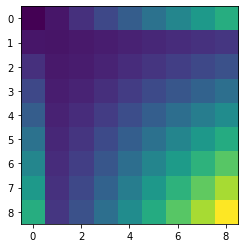

In [192]:
shells = [A2,A1]
Ns = len(shells)
Ni = 0
for shell in range(Ns):
    Ni += NC(shells[shell].L)
    
i = 0
P_start = np.zeros(Ns,int)
for ai in range(Ns):
    P_start[ai] = i
    i += NC(shells[ai].L)
    
P = np.zeros((Ni,Ni))
for ai in range(Ni):
    for bi in range(Ni):
        P[ai,bi] = 1./(ai+1) + 4./(bi+1) + 5*(ai+bi)/(ai*bi+1) + ai * bi 
P += P.T
P /= np.sqrt(np.sum(P**2))
print('Density matrix:')
print(P.shape)
print(P_start)
_ = plt.imshow(P)
plt.show()

In [193]:
# gradient of the exchange 

grad_n = np.zeros((Ns,3))
grad_e = np.zeros((Ns,3))
dx = 1.e-5

Exc0 = 0.
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                I = OS( a,c,b,d )
                sa,sb,sc,sd = P_start[ai],P_start[bi],P_start[ci],P_start[di]
                na,nb,nc,nd = NC(a.L),NC(b.L),NC(c.L),NC(d.L)
                Pab = P[sa:sa+na,sb:sb+nb]
                Pcd = P[sc:sc+nc,sd:sd+nd]
                Exc0 += np.einsum('ij,kl,ikjl',Pab, Pcd, I)

o = 0                
for A in shells:
    for dd in [0,1,2]:
        ExcP = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
                        I = OS( a,c,b,d )
                        sa,sb,sc,sd = P_start[ai],P_start[bi],P_start[ci],P_start[di]
                        na,nb,nc,nd = NC(a.L),NC(b.L),NC(c.L),NC(d.L)
                        Pab = P[sa:sa+na,sb:sb+nb]
                        Pcd = P[sc:sc+nc,sd:sd+nd]
                        ExcP += np.einsum('ij,kl,ikjl',Pab, Pcd, I)
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
        ExcM = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
                        I = OS( a,c,b,d )
                        sa,sb,sc,sd = P_start[ai],P_start[bi],P_start[ci],P_start[di]
                        na,nb,nc,nd = NC(a.L),NC(b.L),NC(c.L),NC(d.L)
                        Pab = P[sa:sa+na,sb:sb+nb]
                        Pcd = P[sc:sc+nc,sd:sd+nd]
                        ExcM += np.einsum('ij,kl,ikjl',Pab, Pcd, I)
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
        
        best_val = (ExcP - ExcM) / dx / 2
        uppr_val = (ExcP - Exc0)/dx
        down_val = (Exc0 - ExcM)/dx
        grad_n[o][dd] = best_val
        grad_e[o][dd] = max(abs(best_val-uppr_val),abs(best_val-down_val))
    o += 1
    
print('Numerical Grad:')
print(grad_n)
print('+/-')
print(grad_e)
print()
print('Total grad:', np.sum(grad_n,axis=0))


Numerical Grad:
[[ 0.00052555 -0.0002976  -0.00015375]
 [-0.00052555  0.0002976   0.00015375]]
+/-
[[2.21291084e-09 6.61361157e-09 7.67403719e-09]
 [2.21291084e-09 6.61360073e-09 7.67404803e-09]]

Total grad: [0.00000000e+00 3.25260652e-14 1.08420217e-14]


In [194]:
# cp2k-style-simmetry exchange gradient

grad = np.zeros((Ns,3))
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                
                if di < ci:
                    continue
                if bi < ai:
                    continue
                if ai == bi and ai == ci and ai == di:
                    continue
                if not (ci + di <= ai + bi):
                    continue
                if ai + bi == ci + di and ci < ai:
                    continue

                symm_fac = 0.5
                if (ai == bi):
                    symm_fac = symm_fac*2.0
                if (ci == di):
                    symm_fac = symm_fac*2.0
                if (ai == ci and bi == di and ai != bi and ci != di):
                    symm_fac = symm_fac*2.0
                if (ai == ci and ai == bi and ci == di):
                    symm_fac = symm_fac*2.0

                symm_fac = 1./symm_fac
                    
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                # note, cp2k exchanges the density instead of the integrals
                DI = OS_grad( a,b, c,d )
                
                sa,sb,sc,sd = P_start[ai],P_start[bi],P_start[ci],P_start[di]
                na,nb,nc,nd = NC(a.L),NC(b.L),NC(c.L),NC(d.L)
                Pac = P[sa:sa+na,sc:sc+nc]
                Pad = P[sa:sa+na,sd:sd+nd]
                Pbc = P[sb:sb+nb,sc:sc+nc]
                Pbd = P[sb:sb+nb,sd:sd+nd]
                        
                grad[ai] += 2*symm_fac* np.einsum('ik,jl,ijkld',Pac, Pbd, DI[:,:,:,:,0])
                grad[ai] += 2*symm_fac* np.einsum('il,jk,ijkld',Pad, Pbc, DI[:,:,:,:,0])
        
                grad[bi] += 2*symm_fac* np.einsum('ik,jl,ijkld',Pac, Pbd, DI[:,:,:,:,1])
                grad[bi] += 2*symm_fac* np.einsum('il,jk,ijkld',Pad, Pbc, DI[:,:,:,:,1])
                
                grad[ci] += 2*symm_fac* np.einsum('ik,jl,ijkld',Pac, Pbd, DI[:,:,:,:,2])
                grad[ci] += 2*symm_fac* np.einsum('il,jk,ijkld',Pad, Pbc, DI[:,:,:,:,2])
                
                grad[di] += 2*symm_fac* np.einsum('ik,jl,ijkld',Pac, Pbd, DI[:,:,:,:,3])
                grad[di] += 2*symm_fac* np.einsum('il,jk,ijkld',Pad, Pbc, DI[:,:,:,:,3])
                
#                print( ai+1 , bi+1, ci+1, di+1, )
        

print('Analytical Grad:')          
print(grad)
print()
print('Analytical / Numerical:')
print(grad / grad_n)
print()
print('Analytical - Numerical:')
print(grad - grad_n)
print()
print('Total grad:', np.sum(grad,axis=0))

ratio_check = np.any( np.abs(grad/grad_n)-1 > 0.001 )
diff__check = np.any( np.abs(grad-grad_n)   > 0.001 )
failed = diff__check or ratio_check
success = not failed

print()
print()
print('Grad check:', end=' ')
if success:
    print('PASS')
else:
    print('FAIL')
print()

Analytical Grad:
[[ 0.00052555 -0.0002976  -0.00015375]
 [-0.00052555  0.0002976   0.00015375]]

Analytical / Numerical:
[[1. 1. 1.]
 [1. 1. 1.]]

Analytical - Numerical:
[[ 2.80236988e-14 -5.00426523e-14  1.42191760e-14]
 [-2.80238072e-14  1.75162619e-14 -2.50611164e-14]]

Total grad: [-1.08420217e-19 -3.25260652e-19  8.13151629e-20]


Grad check: PASS



In [24]:
hyp,alt,cnt,mem_by_L,off = OS_hyp( A2,A0,A0,A1 )
mem_by_L

Plan
{(1, 0, 0, 0, 0, 'A'), (2, 0, 0, 1, 0, 'D'), (2, 0, 0, 0, 0, 'A'), (0, 0, 0, 0, 0, 'S'), (2, 0, 0, 0, 1, 'A'), (0, 0, 0, 0, 1, 'S'), (0, 0, 0, 0, 2, 'S'), (0, 0, 0, 0, 3, 'S'), (1, 0, 0, 0, 1, 'A'), (1, 0, 0, 0, 2, 'A')}

Sorted Plan
[(0, 0, 0, 0, 0, 'S'), (0, 0, 0, 0, 1, 'S'), (0, 0, 0, 0, 2, 'S'), (0, 0, 0, 0, 3, 'S'), (1, 0, 0, 0, 0, 'A'), (1, 0, 0, 0, 1, 'A'), (1, 0, 0, 0, 2, 'A'), (2, 0, 0, 0, 0, 'A'), (2, 0, 0, 0, 1, 'A'), (2, 0, 0, 1, 0, 'D')]



defaultdict(int, {0: 4, 1: 9, 2: 12, 3: 18})

In [25]:
cnt.most_common(8)

[(((0, 0, 0, 0, 1), (0, 0, 0, 0)), 12),
 (((0, 0, 0, 0, 2), (0, 0, 0, 0)), 9),
 (((1, 0, 0, 0, 1), (2, 0, 0, 0)), 9),
 (((1, 0, 0, 0, 1), (1, 0, 0, 0)), 7),
 (((0, 0, 0, 0, 0), (0, 0, 0, 0)), 6),
 (((1, 0, 0, 0, 1), (0, 0, 0, 0)), 5),
 (((0, 0, 0, 0, 3), (0, 0, 0, 0)), 3),
 (((1, 0, 0, 0, 0), (2, 0, 0, 0)), 3)]

In [26]:
for k,v in alt.items():
#    print()
#    print(k)
    la,lb,lc,ld,m = k
    l = la+lb+lc+ld
    name = 'tmp_'+str(l)#+'_'+str(la)+str(lb)+str(lc)+str(ld)#+str(m)

    for i,op in enumerate(v.flatten()):
        print('      ', name+'['+'prm+N_prm*'+str(off[(la,lb,lc,ld,m)]+i)+'] =', op, ';')
    print()
        

In [27]:
for i,op in enumerate(hyp.flatten()):
    print('      tmp_out[',i,'] += ', op, ';')
    

print()

      tmp_out[ 0 ] +=  QDX*(PAX*(PAX*(s0) + WPX*(s1)) + WPX*(PAX*(s1) + WPX*(s2)) + zp1*1*(s0) + zp2*1*(s1)) + WQX*(PAX*(PAX*(s1) + WPX*(s2)) + WPX*(PAX*(s2) + WPX*(s3)) + zp1*1*(s1) + zp2*1*(s2)) + i2z*2*(PAX*(s1) + WPX*(s2)) ;
      tmp_out[ 1 ] +=  QDY*(PAX*(PAX*(s0) + WPX*(s1)) + WPX*(PAX*(s1) + WPX*(s2)) + zp1*1*(s0) + zp2*1*(s1)) + WQY*(PAX*(PAX*(s1) + WPX*(s2)) + WPX*(PAX*(s2) + WPX*(s3)) + zp1*1*(s1) + zp2*1*(s2)) ;
      tmp_out[ 2 ] +=  QDZ*(PAX*(PAX*(s0) + WPX*(s1)) + WPX*(PAX*(s1) + WPX*(s2)) + zp1*1*(s0) + zp2*1*(s1)) + WQZ*(PAX*(PAX*(s1) + WPX*(s2)) + WPX*(PAX*(s2) + WPX*(s3)) + zp1*1*(s1) + zp2*1*(s2)) ;
      tmp_out[ 3 ] +=  QDX*(PAX*(PAY*(s0) + WPY*(s1)) + WPX*(PAY*(s1) + WPY*(s2))) + WQX*(PAX*(PAY*(s1) + WPY*(s2)) + WPX*(PAY*(s2) + WPY*(s3))) + i2z*1*(PAY*(s1) + WPY*(s2)) ;
      tmp_out[ 4 ] +=  QDY*(PAX*(PAY*(s0) + WPY*(s1)) + WPX*(PAY*(s1) + WPY*(s2))) + WQY*(PAX*(PAY*(s1) + WPY*(s2)) + WPX*(PAY*(s2) + WPY*(s3))) + i2z*1*(PAX*(s1) + WPX*(s2)) ;
      tmp_out[ 5 ] 

#min_threshold = 16
#red_cnt = {k: v for k, v in cnt.items() if v >= min_threshold}
#red_cnt = Counter(red_cnt)
#red_cnt

In [28]:
op = hyp[0,0,0,0]

import re

tok = re.split('(\*|\(|\)|\+ )', op)

repl = ['PAX','PAY','PAZ','PBX','PBY','PBZ','QCX','QCY','QCZ','QDX','QDY','QDZ','WPX','WPY','WPZ','WQX','WQY','WQZ']
repl.append( 'zp1' )
repl.append( 'zp2' )
repl.append( 'zq1' )
repl.append( 'zq2' )
repl.append( 'i2z' )

print(repl)

wer = []
idx = []
idx_c = 0
for token in tok:
    if token in repl:
        wer.append( 'aux[idx['+str(idx_c)+']]')
        idx.append(repl.index(token))
        idx_c += 1
    else:
        wer.append(token)
print(''.join([str(x) for x in wer]))
print(idx)


['PAX', 'PAY', 'PAZ', 'PBX', 'PBY', 'PBZ', 'QCX', 'QCY', 'QCZ', 'QDX', 'QDY', 'QDZ', 'WPX', 'WPY', 'WPZ', 'WQX', 'WQY', 'WQZ', 'zp1', 'zp2', 'zq1', 'zq2', 'i2z']
aux[idx[0]]*(aux[idx[1]]*(aux[idx[2]]*(s0) + aux[idx[3]]*(s1)) + aux[idx[4]]*(aux[idx[5]]*(s1) + aux[idx[6]]*(s2)) + aux[idx[7]]*1*(s0) + aux[idx[8]]*1*(s1)) + aux[idx[9]]*(aux[idx[10]]*(aux[idx[11]]*(s1) + aux[idx[12]]*(s2)) + aux[idx[13]]*(aux[idx[14]]*(s2) + aux[idx[15]]*(s3)) + aux[idx[16]]*1*(s1) + aux[idx[17]]*1*(s2)) + aux[idx[18]]*2*(aux[idx[19]]*(s1) + aux[idx[20]]*(s2))
[9, 0, 0, 12, 12, 0, 12, 18, 19, 15, 0, 0, 12, 12, 0, 12, 18, 19, 22, 0, 12]


In [29]:
plan = set()
make_plan( A2.L, A2.L, A2.L, A2.L , 0, plan)
EL_plan = sorted(plan, key=cmp_to_key(compare_Ops),reverse=False)
plan = EL_plan

_, plan = collapse_m_plan( plan )

mem_by_L = defaultdict(int)
for op in plan:
    la,lb,lc,ld,d = op
    nm = plan[op] + 1
    l = la+lb+lc+ld
    mem = NC(la)*NC(lb)*NC(lc)*NC(ld)*nm
    print ( op , l,nm, mem )
    mem_by_L[l] += mem
mem_by_L

(0, 0, 0, 0, 'S') 0 9 9
(0, 1, 0, 0, 'B') 1 6 18
(1, 0, 0, 0, 'A') 1 8 24
(0, 1, 1, 0, 'C') 2 4 36
(1, 1, 0, 0, 'B') 2 6 54
(2, 0, 0, 0, 'A') 2 7 42
(0, 2, 0, 0, 'B') 2 5 30
(1, 0, 1, 0, 'C') 2 4 36
(1, 2, 0, 0, 'B') 3 5 90
(0, 2, 1, 0, 'C') 3 4 72
(2, 1, 0, 0, 'B') 3 6 108
(1, 1, 1, 0, 'C') 3 4 108
(2, 0, 1, 0, 'C') 3 4 72
(2, 2, 0, 0, 'B') 4 5 180
(1, 1, 2, 0, 'C') 4 3 162
(1, 2, 1, 0, 'C') 4 4 216
(2, 0, 2, 0, 'C') 4 3 108
(2, 1, 1, 0, 'C') 4 4 216
(0, 2, 2, 0, 'C') 4 3 108
(2, 1, 2, 0, 'C') 5 3 324
(2, 2, 1, 0, 'C') 5 4 432
(1, 2, 2, 0, 'C') 5 3 324
(2, 1, 2, 1, 'D') 6 2 648
(2, 2, 2, 0, 'C') 6 3 648
(2, 2, 1, 1, 'D') 6 2 648
(1, 2, 2, 1, 'D') 6 2 648
(2, 2, 2, 1, 'D') 7 2 1296
(2, 2, 2, 2, 'D') 8 1 1296


defaultdict(int,
            {0: 9,
             1: 42,
             2: 198,
             3: 450,
             4: 990,
             5: 1080,
             6: 2592,
             7: 1296,
             8: 1296})

In [35]:
#mol_h2o = pyscf.gto.M(atom = 'O 1. 0. 0.')
#mol_h2o = pyscf.gto.M(atom = 'H 0 0 0; H 0.1 0.2 0.3')
#mol_h2o = pyscf.gto.M(atom = 'O 0 0 0;')
mol_h2o = pyscf.gto.M(atom = 'O 0 0 0; H 0 1. 0; H 0.1 0.2 0.3')
# basis = {atom_type1:[[angular_momentum
#                       (GTO-exp1, contract-coeff11, contract-coeff12),
#mol_h2o.basis = {'H': [[0,[1.,1.]], [4,[1.,1.]]]}
#mol_h2o.basis = {'O': [[0,[2.,.5,0.],[1.,.5,1.],[.5,.25,1.]], [1,[2.,1.]]],'H': [[0,[2.,1.]], [2,[2.,1.]]] }
mol_h2o.basis = '631g'
#mol_h2o.basis = '631g'
#mol_h2o.basis = 'ccpvdz'
mol_h2o.build()


ijkl = mol_h2o.intor("int2e_cart")
while np.isnan(ijkl).any():
    ijkl = mol_h2o.intor("int2e_cart")

print('---- ATM ----')
print(mol_h2o._atm)
print('---- BAS ----')
print(mol_h2o._bas)
print('---- ENV ----')
print(mol_h2o._env[20:])
print('---- ERI ----')
print(ijkl.shape)
atm = mol_h2o._atm
bas = mol_h2o._bas
env = mol_h2o._env    
    
print('##################################')
def Lcorrection(L):
    if L == 0:
        return 1.0
    elif L == 1:
        return np.sqrt(3)
    else:
        return 2 * np.sqrt(np.pi)

---- ATM ----
[[ 8 20  1 23  0  0]
 [ 1 24  1 27  0  0]
 [ 1 28  1 31  0  0]]
---- BAS ----
[[ 0  0  6  1  0 32 38  0]
 [ 0  0  3  1  0 44 47  0]
 [ 0  0  1  1  0 50 51  0]
 [ 0  1  3  1  0 52 55  0]
 [ 0  1  1  1  0 58 59  0]
 [ 1  0  3  1  0 60 63  0]
 [ 1  0  1  1  0 66 67  0]
 [ 2  0  3  1  0 60 63  0]
 [ 2  0  1  1  0 66 67  0]]
---- ENV ----
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.88972612e+00  0.00000000e+00  0.00000000e+00
  1.88972612e-01  3.77945225e-01  5.66917837e-01  0.00000000e+00
  5.48467170e+03  8.25234950e+02  1.88046960e+02  5.29645000e+01
  1.68975700e+01  5.79963530e+00  2.94842455e+00  5.42657124e+00
  8.78126489e+00  1.15432129e+01  9.90055015e+00  3.38516599e+00
  1.55396160e+01  3.59993360e+00  1.01376180e+00 -2.19051792e+00
 -9.77405528e-01  2.88629094e+00  2.70005800e-01  9.46334873e-01
  1.55396160e+01  3.59993360e+00  1.01376180e+00  6.37930734e+00
  4.91490975e+00  2.15791055e+00  2.70005800e-01  5.67807022e-01


In [38]:
shells = []
for i, shell in enumerate(bas):
    a_ii, l, npr, nc, _, z_i, k_i, _ = shell
    a_i = atm[a_ii][1]
    
    A   = Shell( i, l, npr, nc )
    A.z = env[z_i:z_i+npr]
    A.R = env[a_i:a_i+3]
    A.k = env[k_i:k_i+npr]
    shells.append(A)
shells


print('/', len(shells), '/', end=' ')

oi = 0
for a in shells:
    oj = 0
    print(a.i, end=' ')
    for b in shells:
        ok = 0
        for c in shells:
            ol = 0
            for d in shells:
                
                val = OS( a,b,c,d ) * Lcorrection(a.L) * Lcorrection(b.L) * Lcorrection(c.L) * Lcorrection(d.L)
                ref = ijkl[ oi:oi+NC(a.L), oj:oj+NC(b.L) , ok:ok+NC(c.L) , ol:ol+NC(d.L)]
                
                diff = np.sum(np.abs(ref-val))
                
                if diff > 1.e-6:
                    print()
                    print('error at ', a.i,b.i,c.i,d.i )
                    print(val,ref)
                    print()
                ol += NC(d.L)
            ok += NC(c.L)
        oj += NC(b.L)
    oi += NC(a.L)
print('/', len(shells))

/ 9 /
0 1 2 3 4 5 6 7 8 / 9


In [37]:
idx_l(6)

([6,
  5,
  5,
  4,
  4,
  4,
  3,
  3,
  3,
  3,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  1,
  0,
  2,
  1,
  0,
  3,
  2,
  1,
  0,
  4,
  3,
  2,
  1,
  0,
  5,
  4,
  3,
  2,
  1,
  0,
  6,
  5,
  4,
  3,
  2,
  1,
  0],
 [0,
  0,
  1,
  0,
  1,
  2,
  0,
  1,
  2,
  3,
  0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4,
  5,
  0,
  1,
  2,
  3,
  4,
  5,
  6],
 ['X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'X',
  'Y',
  'Y',
  'Y',
  'Y',
  'Y',
  'Y',
  'Z'],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  15,
  16,
  17,
  18,
  19,
  20,
  20],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  10,
  11,
  12,
  13,
  14,
  15,
  14],
 defaultdict(int,
             {(0, 0, 0, 0): 0,
             